# Bandlimited quadratures using method from Reynolds, Beylkin, Monzon 2013

### Note: this code works well for generating quadratures that are accurate to double precision. However, because it uses "BigFloats," it is slow. For practical applications where speed matters one should seek out packages that enable use of quad precision.

In [2]:
#using Pkg
#Pkg.add("GenericLinearAlgebra")
using LinearAlgebra
using GenericLinearAlgebra

using Plots

# Use roughly quad precision
setprecision(128)

128

In [3]:
# Create functional samples to fill Toeplitz matrix. Note that you need an odd number of samples
# and that the weight function must be included in the sampling

c = BigFloat(50) # bandlimit parameter
num_samples = 501
@assert mod(num_samples,2)!=0

N = BigFloat((num_samples-1)/2)
N_int = convert(Int128,N)
G = [2*sinc(c*n/N/BigFloat(pi)) for n=-N:N];# computed by evaluating integral (6) in the paper. 1/pi to remove pi in Julia sinc expression

In [4]:
# Form a Toeplitz matrix from the samples G. Note: be careful with data types!
G_matrix = zeros(BigFloat,N_int+1,N_int+1)
for n = 0:N_int
    for np = 0:N_int
        G_matrix[n+1,np+1] = G[n-np+N_int+1]
    end
end

In [5]:
# compute the SVD
U,s,V = svd(G_matrix);

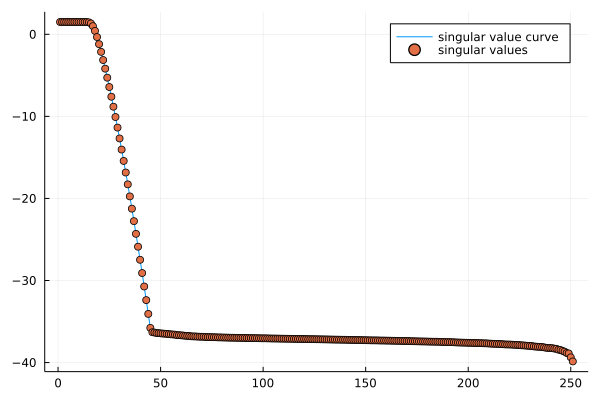

In [6]:
# plot the singular values, figure out which one you want
plot(log10.(s),label="singular value curve")
scatter!(1:length(s),log10.(s),label="singular values")

In [7]:
# Select singular value index. Note that this number +1 should give you the accuracy you want
s_index=32
s[s_index]/s[1]

1.181610615559474770475401369562367147195e-17

In [8]:
# Carve up U and construct the eigenvalue matrix
U_tilde = U[1:N_int,1:s_index];
U_hat = U[2:N_int+1,1:s_index];

C_matrix = pinv(U_tilde)*U_hat;

In [9]:
# compute the eigenvalues of the matrix
eig_vals_C = eigvals(C_matrix);

In [10]:
# Note these are slightly off the unit circle (because of the SVD step; truncated Toeplitz isn't Toeplitz).
# Project them back onto the unit circle to get nodes (ok because they are close).
nodes = exp.(im*angle.(eig_vals_C));

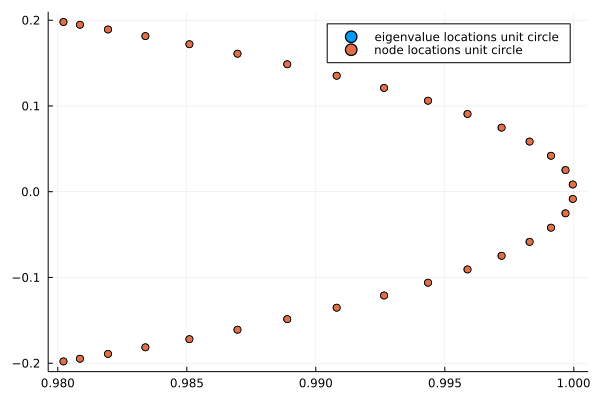

In [11]:
scatter(real(eig_vals_C),imag(eig_vals_C),label="eigenvalue locations unit circle")
scatter!(real(nodes),imag(nodes),label="node locations unit circle")

In [12]:
# compute the quadrature weights. Form a vandermonde matrix and solve using least squares
V_matrix = zeros(Complex{BigFloat},2*N_int+1,s_index)
n_minus_np =-N:N
for i = 1:num_samples
    for j in 1:s_index
        V_matrix[i,j]= nodes[j]^n_minus_np[i]
    end
end

weights = real(V_matrix \ G);

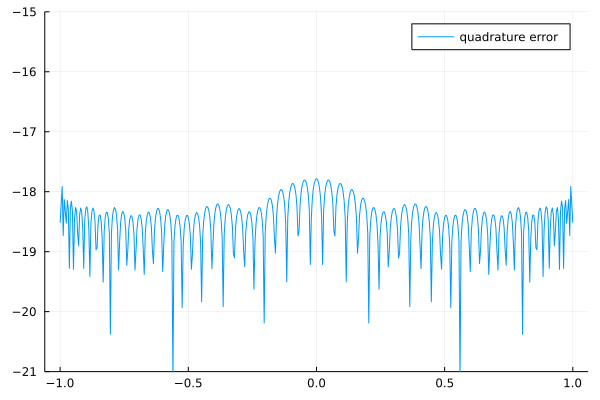

In [13]:
plot(range(-1,stop=1,length=num_samples),log10.(abs.(V_matrix*weights-G)),ylims=(-21,-15),label="quadrature error")

In [14]:
maximum(abs.(V_matrix*weights-G))

1.646225070112712371394268888794735979852e-18

In [15]:
# Extract quadrature nodes on [-1,1] from the nodes on the unit circle
quadrature_nodes = real(N/im/c*log.(nodes));

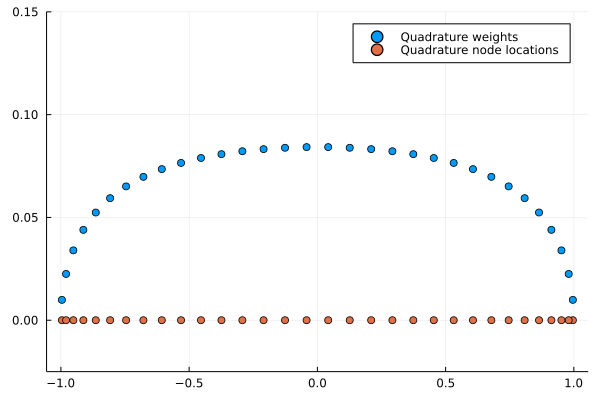

In [16]:
scatter(quadrature_nodes,weights,ylims=(-0,.25),label="Quadrature weights")
scatter!(quadrature_nodes,zeros(length(quadrature_nodes)),ylims=(-0.025,.15),label="Quadrature node locations")